In [ ]:
# import core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

In [ ]:
# load Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence
import pickle

In [ ]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)

In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'rb') as fp:
        smiles = pickle.load(fp)

    return smiles

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [ ]:
# load dataset & break into train/test sets
smifile = '/content/valid_smiles_data'
data = load_data(smifile)
data = [mol for mol in data if len(mol) < 99]
data = np.array(data)
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training smiles shape:", full_train.shape)
print("Test smiles shape:", test.shape)
print("Sample training smile: \n", full_train[0])

In [ ]:
# # save test file for smile generation
# np.save('/drive/My Drive/chem_data/test.npy', test)
# print('Test file saved to disk')

In [ ]:
# create our validation dataset
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)
print("Training dataset shape:", train.shape)
print("Validation dataset shape:", val_set.shape)

In [ ]:
#find unique chars
chars = []
for mol in data:
  chars.append(set(mol))

chars = list(set([i for mol in chars for i in mol]))
chars.append('E')
chars.append('!')
print(chars)

In [ ]:
#Create array from characters in the dataset
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from numpy import array

values = array(chars)
# print("Array of unique characters:")
# print(values)

#Create unique, numerical labels for each character between 0 and n-1, where n is the number of unique characters
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
#print("Array of labels for each character:")
#print(integer_encoded)

values = np.reshape(values, (np.shape(values)[0], 1))
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#print(values.shape)
vocab = np.concatenate((values, integer_encoded.astype(object)), axis = 1)
vocab = vocab[vocab[:,1].argsort()]
#print(vocab)
int_to_char = {}
char_to_int = {}
for row in vocab:
  int_to_char[str(row[1])]=row[0]
  char_to_int[row[0]] = row[1]
print(int_to_char)
print(char_to_int)

In [ ]:
# load the dictionaries that map characters-to-integers and intergers-to-characters
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

In [ ]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #print(one_hot)
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y datasets
embed = 101
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Validation input shape:", X_val.shape)
print("Validation output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

In [ ]:
"".join([int_to_char[str(idx)] for idx in np.argmax(X_train[0,:,:], axis=1)])

In [ ]:
# define the LSTM Chem model
def lstm_model(X, y):
    # define the encoder layers
    enc_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(enc_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    bottle_neck = Dense(128, activation='relu')(states)

    # define the decoder layers
    state_h_decoded = Dense(256, activation='relu')(bottle_neck)
    state_c_decoded = Dense(256, activation='relu')(bottle_neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    dec_input = Input(shape=(X.shape[1:]))
    dec1 = LSTM(256, return_sequences=True)(dec_input, initial_state=encoder_states)
    output = Dense(y.shape[2], activation='softmax')(dec1)

    model = Model(inputs=[enc_input, dec_input], outputs=output)
    return model

In [ ]:
# instantiate our neural network model
model = lstm_model(X_train, y_train)
model.summary()

In [ ]:
# compile the model
batch_size = 256
steps_per_epoch = len(X_train) // batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=steps_per_epoch*50, decay_rate=1.0, staircase=False)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# define our data sequence generator class
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = np.array(x), np.array(y)

        return [batch_x, batch_x], batch_y

In [ ]:

# create object instances of our sequence generator
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

In [ ]:
# create our callbacks
file="LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
#tb = TensorBoard(log_dir="/drive/My Drive/logs/chem/", histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# fit the model
nb_epochs = 225
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1,
                              validation_data=validation_generator, validation_steps=validation_steps,
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/225
1355/1355 [==============================] - 58s 41ms/step - loss: 0.5786 - acc: 0.8237 - val_loss: 0.3831 - val_acc: 0.8749
Epoch 2/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.3468 - acc: 0.8839 - val_loss: 0.3176 - val_acc: 0.8918
Epoch 3/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.3038 - acc: 0.8953 - val_loss: 0.2894 - val_acc: 0.8993
Epoch 4/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.2831 - acc: 0.9010 - val_loss: 0.2760 - val_acc: 0.9030
Epoch 5/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.2686 - acc: 0.9054 - val_loss: 0.2614 - val_acc: 0.9079
Epoch 6/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.2593 - acc: 0.9083 - val_loss: 0.2538 - val_acc: 0.9101
Epoch 7/225
1355/1355 [==============================] - 54s 40ms/step - loss: 0.2513 - acc: 0.9107 - val_loss: 0.2465 - val_acc: 0.9125
Epoch 8/225
1355/1355 [==================

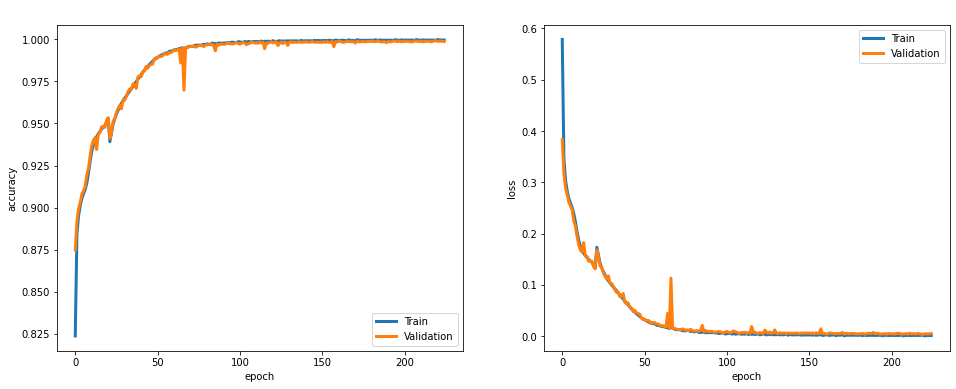

In [ ]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.savefig("TrainValAccuracyLoss.jpg",	format="jpg",	dpi=1200,bbox_inches='tight')
plt.show()

In [ ]:
with open('trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
# evaluate our test set
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch_size, verbose=0)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

In [ ]:
# save our baseline training model & weights
mod_file = 'LSTM_model.h5'
model.save(mod_file)
print("Model Saved")

In [ ]:
import json

with open("char_to_int.json", "w") as outfile:
    json.dump(char_to_int, outfile)
with open("int_to_char.json", "w") as outfile:
    json.dump(int_to_char, outfile)